In [1]:
import os
os.environ["ESMFMKFILE"] = "/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/esmf.mk"
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy
import numpy as np
import pandas as pd
import xarray as xr
import scipy
from scipy import special
from scipy.stats import norm
from scipy.stats import ks_2samp as ks_2samp
import sys 
import xesmf as xe 
import cartopy.feature as cfeature
import cftime
from netCDF4 import Dataset
from netCDF4 import num2date
from statsmodels.stats.multitest import multipletests

In [2]:
# Common parameters to the three resolutions
W=0

if W > 3: 
    W_EMO5 = 4
else : 
    W_EMO5 = W 

    
D = 'ccs'

do_plot = D 

root_dir = '/data/cmcc/ls21622/gcm_driven_experiment_from_nird/'
fig_dir = f'{root_dir}/scripts/python_2/plotter/hws/figures' 


boundaries = np.array([1,16.9,40.5,50]) ; min_lon,max_lon,min_lat,max_lat = boundaries

to_tit = ['HWs mean Tmax', 'HWs max Tmax', 'HWs persistence', 'HWMId',
          'HWs mean HFLS','HW evap. deficit','HWs count']

clabs=["°C","°C","days","HWMId","W/m^2","Evap. deficit","N."]

variables=['HW_mean_tmax','HW_max_tmax','HW_persistence','HW_HWMI',
           'HW_mean_hfls','HW_hfls_deficit','HW_number']

var = variables[W]

variables_to_tit = ['HWs mean Tmax', 'HWs max Tmax', 'HWs persistence', 'HWMId',
                    'HW mean hfls','HW evap. deficit','HWs number'] 

var_to_tit = variables_to_tit[W]

execute_array_his = ['ds_his.HW_mean_tmax','ds_his.HW_max_tmax','ds_his.HW_persistence',
                     'ds_his.HW_HWMI','ds_his.HW_mean_hfls','ds_his.HW_hfls_deficit',
                     'ds_his.HW_number']

execute_array_rcp85 = ['ds_rcp85.HW_mean_tmax','ds_rcp85.HW_max_tmax','ds_rcp85.HW_persistence',
                       'ds_rcp85.HW_HWMI','ds_rcp85.HW_mean_hfls','ds_rcp85.HW_hfls_deficit',
                       'ds_rcp85.HW_number']


if do_plot == 'his' :
        
        cmin =        [ 15,  15,   3,   4,   10,  0,     0  ]
        cmax =        [ 40,  42,   7,  13,  130,  7,     3  ]
        cint =        [ 26,  28,   5,  10,   25,  15,    7  ]
        cmin_bias =   [-6,   -6,  -3,  -7,   -3,  -3,   -3  ]
        cmax_bias=    [ 6,    6,   3,   7,    3,   3,    3  ]
        cint_bias=    [ 13,  13,   7,  15,    7,   7,    7  ]
        cmin_spread = [.5,   .5,   0,   0,   10,   0,    0  ]
        cmax_spread = [ 5,    5, 2.5,   5,   50,  12,  2.0  ]
        cint_spread = [.5,   .5,  .5,  .5,    5,   1,   .5  ]
        levels_his  = np.linspace(cmin[W],cmax[W],cint[W])
        levels_bias = np.linspace(cmin_bias[W],cmax_bias[W],cint_bias[W])
        levels_std  = np.arange(cmin_spread[W],cmax_spread[W],cint_spread[W])

else :
        cmin=         [ 1,   1,   1,  10,  -60, -30,   0  ]
        cmax=         [ 6,   8,  25,  65,   60,  30,   6  ]
        cint=         [ 11,  15, 25,  11,   21,  21,   7  ]       
        cmin_spread = [.5,  .5,   1,   0,   10,   0,   0  ]
        cmax_spread = [ 3,   4,  18,  40,   30,  44,   3  ]
        cint_spread = [.5,  .5,   1,   4,   2,    4,  .5  ]
        levels_ccs  = np.linspace(cmin[W],cmax[W],cint[W])
        levels_std  = np.arange(cmin_spread[W],cmax_spread[W],cint_spread[W])
        
        
colormap_his = ['turbo', 'turbo',  'turbo', 'turbo', 'turbo_r', 'turbo', 'turbo']
colormap_bias = 'coolwarm'
colormap_ccs = ['YlOrRd','YlOrRd', 'YlOrRd','YlOrRd','PuOr_r', 'PuOr_r', 'YlOrRd']
colormap_ccs = ['YlOrRd','YlOrRd', 'YlOrRd','YlOrRd','Spectral', 'Spectral_r', 'YlOrRd']
colormap_std = 'viridis'

## RCMs

In [3]:
res='RCM'

models_ranked_to_plot = [ 'BCCR-AUTH','FZJ-IDL','BTU','CMCC','KIT','ETHZ',
                         'HCLIM','KNMI','CNRM','ICTP','UKMO']
models = [ 'BCCR-AUTH','BTU','CMCC','CNRM','ETHZ','FZJ-IDL','HCLIM',
          'ICTP','KIT','KNMI','UKMO']

dir_home_his    = f'{root_dir}/scripts/python_2/hws/OUTPUTS/historical/nonCP'

dir_home_rcp85   = f'{root_dir}/scripts/python_2/hws/OUTPUTS/rcp85/nonCP'

# Load datasets
ds_his = []
ds_his = xr.open_mfdataset(f'{dir_home_his}/*.nc',combine='nested',concat_dim='model')
ds_his.load()
ds_his = ds_his.sel(model=models_ranked_to_plot)
ds_his['lat'] = ds_his.lat.mean(dim='model')
ds_his['lon'] = ds_his.lon.mean(dim='model')

ds_rcp85 = []
ds_rcp85 = xr.open_mfdataset(f'{dir_home_rcp85}/*.nc',combine='nested',concat_dim='model')
ds_rcp85.load()
ds_rcp85 = ds_rcp85.sel(model=models_ranked_to_plot)
ds_rcp85['lat'] = ds_rcp85.lat.mean(dim='model')
ds_rcp85['lon'] = ds_rcp85.lon.mean(dim='model')
#ds_rcp85 = ds_rcp85.rename({'x': 'lon', 'y': 'lat'})

if do_plot == 'his' :
    if W < 2 : 
        V_rcm = eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='RCMs')-273.16
        #V_rcm = eval(execute_array_his[W]).mean(dim='time').mean(dim='model').assign_coords(ENS='RCMs')-273.16
    else : 
        V_rcm = eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='RCMs')  
        #V_rcm = eval(execute_array_his[W]).mean(dim='time').mean(dim='model').assign_coords(ENS='RCMs')      
    V_rcm = V_rcm.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    V_rcm_std = eval(execute_array_his[W]).mean(dim='time').std(dim='model').assign_coords(ENS='RCMs')
    
if do_plot == 'ccs' : 
    V_rcm = eval(execute_array_rcp85[W]).mean(dim='time').quantile(.5, dim='model') - eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='RCMs')
    V_rcm = V_rcm.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    V_rcm_std = np.std(eval(execute_array_rcp85[W]).mean(dim='time') - eval(execute_array_his[W]).mean(dim='time').assign_coords(ENS='RCMs'),axis=0)
    V_rcm_std = V_rcm_std.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    
    dummy_p_mat = np.empty([len(models),ds_his.HW_mean_tmax.shape[2],ds_his.HW_mean_tmax.shape[3]])
    dummy_p_mat_fdr = np.empty([len(models),ds_his.HW_mean_tmax.shape[2],ds_his.HW_mean_tmax.shape[3]])
    trend_signs = np.empty([len(models), ds_his.HW_mean_tmax.shape[2], ds_his.HW_mean_tmax.shape[3]])

    for i in range(0,len(models)) :
        
        V = eval(execute_array_rcp85[W])[i,:,:,:].mean(dim=('time')) - eval(execute_array_his[W])[i,:,:,:].mean(dim=('time'))

        H = eval(execute_array_his[W])[i,:,:,:];   
        F = eval(execute_array_rcp85[W])[i,:,:,:]; 
            
        # Compute ttest for each model
        s,p=scipy.stats.ttest_ind(H ,F, axis=0, equal_var=False,nan_policy='omit')
        
        dummy_p_mat[i,:,:] = p 
        trend_signs[i, :, :] = np.sign(s)  # Store the sign of the trend based on t-statistic `s`
        
        # FDR
        # Debug: Print shape of p
        print(f"Shape of p-values (original): {p.shape}")
            
        # Flatten the p-values and retain a mask of non-NaN values
        p_values_flat = p.flatten()
        non_nan_mask = ~np.isnan(p_values_flat)
            
        # Filter non-NaN p-values
        p_values_filtered = p_values_flat[non_nan_mask]
        
        # Debug: Check p-values filtering
        print(f"Number of non-NaN p-values: {len(p_values_filtered)}")
        print(f"Non-NaN mask sum: {non_nan_mask.sum()}")
        
        # If no valid p-values are present, skip to the next iteration
        if len(p_values_filtered) == 0:
            print("No valid p-values for this iteration, skipping.")
            
            
        # Apply FDR correction
        _, corrected_p_values, _, _ = multipletests(p_values_filtered, alpha=0.05, method='fdr_bh')
        
        # Debug: Print size of corrected p-values
        print(f"Size of corrected p-values: {len(corrected_p_values)}")
        
        # Create an array filled with NaNs (same shape as `p`)
        corrected_p_values_mat = np.full(p.shape, np.nan)
        
        # Instead of using flatten, index directly into the flattened view
        np.put(corrected_p_values_mat, np.where(non_nan_mask)[0], corrected_p_values)
        
        # Store the corrected p-values into dummy_p_mat_fdr
        dummy_p_mat_fdr[i, :, :] = corrected_p_values_mat
        
        # Debug: Check if corrected_p_values_mat contains values other than NaN
        print(f"Corrected p-values matrix contains {np.sum(~np.isnan(corrected_p_values_mat))} non-NaN values")




    # Step 1: Determine the majority sign of the trend at each grid point
    trend_sign_sum = np.nansum(trend_signs, axis=0)
    majority_sign = np.sign(trend_sign_sum)  # +1 if most models show a positive trend, -1 if negative
    
    # Step 2: Filter models that agree with the majority sign
    # Create a mask where models agree with the majority sign
    agreeing_models_mask = (trend_signs == majority_sign)
    
    # Step 3: Check significance only for models that agree with the majority sign
    # Apply the significance test only to models that agree on the sign
    dummy_p_mat[dummy_p_mat > 0.05] = np.NaN
    dummy_p_mat[dummy_p_mat <= 0.05] = 1
    dummy_p_mat_fdr[dummy_p_mat_fdr > 0.05] = np.NaN
    dummy_p_mat_fdr[dummy_p_mat_fdr <= 0.05] = 1

    
    # Count the number of models that are both significant and agree on the trend sign
    significant_and_agreeing = np.nansum(dummy_p_mat * agreeing_models_mask, axis=0)
    # Step 4: Check if 2/3 of the agreeing models are significant
    threshold_significant = 2 / 3 * np.nansum(agreeing_models_mask, axis=0)
    to_stipple = (significant_and_agreeing >= threshold_significant) * (np.nansum(agreeing_models_mask, axis=0) >= 2)
    # Mask grid points where no valid V values exist
    to_stipple = to_stipple.astype(float)
    to_stipple[np.isnan(V)] = np.nan
    to_stipple[to_stipple!=0] = np.nan
    # Convert stippling result to xarray DataArray for output
    to_stipple_rcm = xr.DataArray(to_stipple, name='to_stipple_rcm').assign_coords(ENSEMBLE='RCMs').rename({'dim_0':'lat','dim_1':'lon'})

    # Count the number of models that are both significant and agree on the trend sign
    significant_and_agreeing = np.nansum(dummy_p_mat_fdr * agreeing_models_mask, axis=0)
    # Step 4: Check if 2/3 of the agreeing models are significant
    threshold_significant = 2 / 3 * np.nansum(agreeing_models_mask, axis=0)
    to_stipple = (significant_and_agreeing >= threshold_significant) * (np.nansum(agreeing_models_mask, axis=0) >= 2)
    # Mask grid points where no valid V values exist
    to_stipple = to_stipple.astype(float)
    to_stipple[np.isnan(V)] = np.nan
    to_stipple[to_stipple!=0] = np.nan
    # Convert stippling result to xarray DataArray for output
    to_stipple_rcm_fdr = xr.DataArray(to_stipple, name='to_stipple_rcm').assign_coords(ENSEMBLE='RCMs').rename({'dim_0':'lat','dim_1':'lon'})


/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Shape of p-values (original): (82, 91)
Number of non-NaN p-values: 5275
Non-NaN mask sum: 5275
Size of corrected p-values: 5275
Corrected p-values matrix contains 5275 non-NaN values
Shape of p-values (original): (82, 91)
Number of non-NaN p-values: 5275
Non-NaN mask sum: 5275
Size of corrected p-values: 5275
Corrected p-values matrix contains 5275 non-NaN values
Shape of p-values (original): (82, 91)
Number of non-NaN p-values: 5275
Non-NaN mask sum: 5275
Size of corrected p-values: 5275
Corrected p-values matrix contains 5275 non-NaN values
Shape of p-values (original): (82, 91)
Number of non-NaN p-values: 5274
Non-NaN mask sum: 5274
Size of corrected p-values: 5274
Corrected p-values matrix contains 5274 non-NaN values
Shape of p-values (original): (82, 91)
Number of non-NaN p-values: 5275
Non-NaN mask sum: 5275
Size of corrected p-values: 5275
Corrected p-values matrix contains 5275 non-NaN values
Shape of p-values (original): (82, 91)
Number of non-NaN p-values: 5274
Non-NaN mask 

/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [112]:
res='RCM'

models_ranked_to_plot = [ 'BCCR-AUTH','FZJ-IDL','BTU','CMCC','KIT','ETHZ',
                         'HCLIM','KNMI','CNRM','ICTP','UKMO']
models = [ 'BCCR-AUTH','BTU','CMCC','CNRM','ETHZ','FZJ-IDL','HCLIM',
          'ICTP','KIT','KNMI','UKMO']

dir_home_his    = f'{root_dir}/scripts/python_2/hws/OUTPUTS/historical/nonCP'

dir_home_rcp85   = f'{root_dir}/scripts/python_2/hws/OUTPUTS/rcp85/nonCP'

# Load datasets
ds_his = []
ds_his = xr.open_mfdataset(f'{dir_home_his}/*.nc',combine='nested',concat_dim='model')
ds_his.load()
ds_his = ds_his.sel(model=models_ranked_to_plot)
ds_his['lat'] = ds_his.lat.mean(dim='model')
ds_his['lon'] = ds_his.lon.mean(dim='model')

ds_rcp85 = []
ds_rcp85 = xr.open_mfdataset(f'{dir_home_rcp85}/*.nc',combine='nested',concat_dim='model')
ds_rcp85.load()
ds_rcp85 = ds_rcp85.sel(model=models_ranked_to_plot)
ds_rcp85['lat'] = ds_rcp85.lat.mean(dim='model')
ds_rcp85['lon'] = ds_rcp85.lon.mean(dim='model')

if do_plot == 'his' :
    if W < 2 : 
        V_rcm = eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='RCMs')-273.16
        #V_rcm = eval(execute_array_his[W]).mean(dim='time').mean(dim='model').assign_coords(ENS='RCMs')-273.16
    else : 
        V_rcm = eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='RCMs')  
        #V_rcm = eval(execute_array_his[W]).mean(dim='time').mean(dim='model').assign_coords(ENS='RCMs')      
    V_rcm = V_rcm.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    V_rcm_std = eval(execute_array_his[W]).mean(dim='time').std(dim='model').assign_coords(ENS='RCMs')
    
if do_plot == 'ccs' : 
    V_rcm = eval(execute_array_rcp85[W]).mean(dim='time').quantile(.5, dim='model') - eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='RCMs')
    V_rcm = V_rcm.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    V_rcm_std = np.std(eval(execute_array_rcp85[W]).mean(dim='time') - eval(execute_array_his[W]).mean(dim='time').assign_coords(ENS='RCMs'),axis=0)
    V_rcm_std = V_rcm_std.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    
    dummy_p_mat = np.empty([len(models),ds_his.HW_mean_tmax.shape[2],ds_his.HW_mean_tmax.shape[3]])
    dummy_p_mat_fdr = np.empty([len(models),ds_his.HW_mean_tmax.shape[2],ds_his.HW_mean_tmax.shape[3]])
    trend_signs = np.empty([len(models), ds_his.HW_mean_tmax.shape[2], ds_his.HW_mean_tmax.shape[3]])


    # Iterate through each model to compute the t-test, p-values, and signs
    for i in range(0, len(models)):
        V = eval(execute_array_rcp85[W])[i, :, :, :].mean(dim=('time')) - eval(execute_array_his[W])[i, :, :, :].mean(dim=('time'))
        H = eval(execute_array_his[W])[i, :, :, :]
        F = eval(execute_array_rcp85[W])[i, :, :, :]
        
        # Compute t-test for each model
        s, p = scipy.stats.ttest_ind(H, F, axis=0, equal_var=False, nan_policy='omit')
        
        dummy_p_mat[i, :, :] = p
        trend_signs[i, :, :] = np.sign(s)  # Store the sign of the trend based on t-statistic `s`
        
        # FDR correction
        p_values_flat = p.flatten()
        non_nan_mask = ~np.isnan(p_values_flat)
        p_values_filtered = p_values_flat[non_nan_mask]
        
        if len(p_values_filtered) == 0:
            continue  # Skip if no valid p-values
        
        _, corrected_p_values, _, _ = multipletests(p_values_filtered, alpha=0.05, method='fdr_bh')
        
        corrected_p_values_mat = np.full(p.shape, np.nan)
        np.put(corrected_p_values_mat, np.where(non_nan_mask)[0], corrected_p_values)
        dummy_p_mat_fdr[i, :, :] = corrected_p_values_mat


# Step 1: Test for significant changes using FDR-corrected p-values
# Convert p-values to binary significance mask (1 for significant, NaN for non-significant)
dummy_p_mat[dummy_p_mat > 0.05] = np.NaN
dummy_p_mat[dummy_p_mat <= 0.05] = 1
dummy_p_mat_fdr[dummy_p_mat_fdr > 0.05] = np.NaN
dummy_p_mat_fdr[dummy_p_mat_fdr <= 0.05] = 1


# Step 1: Find how many models show significant trend for each grid point
significant_models_count = np.nansum(dummy_p_mat, axis=0)  # Sum along the model dimension (axis 0)
significant_mask = (np.nansum(~np.isnan(dummy_p_mat),axis=0)/len(models))<.5  # Binary mask for significant trends
# Apply the first mask: Where `significant_mask` is true, keep `significant_models_count`, otherwise set to 9999
to_stipple_mask = np.where(np.isnan(V_rcm), np.nan, significant_mask)
to_stipple_mask_rcm = np.where(to_stipple_mask==0, np.nan, to_stipple_mask)

# Step 2: Find the sign of significant trends from each model
trend_sign = np.where(np.isnan(dummy_p_mat), np.nan, trend_signs)
# Derive trend sign agreement, wherever
trend_sign_agreement = np.nansum(trend_sign,axis=0)
# Derive trend sign agreement only over 50% of model shows significant trend
trend_sign_agreement_masked = np.where(significant_mask==0, trend_sign_agreement, np.nan)

# Derive the percentage of the model agreement over the sign where significant trends result 
trend_sign_agreement_masked_percentage = np.abs(trend_sign_agreement_masked)/significant_models_count
# Mask where significant trend sign agreement is lower than .80
to_hatch_mask_rcm = np.where(trend_sign_agreement_masked_percentage<.66, 1, np.nan)


#fdr-adjusted p-value

# Step 1: Find how many models show significant trend for each grid point
significant_models_count = np.nansum(dummy_p_mat_fdr, axis=0)  # Sum along the model dimension (axis 0)
significant_mask = (np.nansum(~np.isnan(dummy_p_mat_fdr),axis=0)/len(models))<.5  # Binary mask for significant trends
# Apply the first mask: Where `significant_mask` is true, keep `significant_models_count`, otherwise set to 9999
to_stipple_mask = np.where(np.isnan(V_rcm), np.nan, significant_mask)
to_stipple_mask_fdr_rcm = np.where(to_stipple_mask==0, np.nan, to_stipple_mask)

# Step 2: Find the sign of significant trends from each model
trend_sign = np.where(np.isnan(dummy_p_mat_fdr), np.nan, trend_signs)
# Derive trend sign agreement, wherever
trend_sign_agreement = np.nansum(trend_sign,axis=0)
# Derive trend sign agreement only over 50% of model shows significant trend
trend_sign_agreement_masked = np.where(significant_mask==0, trend_sign_agreement, np.nan)

# Derive the percentage of the model agreement over the sign where significant trends result 
trend_sign_agreement_masked_percentage = np.abs(trend_sign_agreement_masked)/significant_models_count
# Mask where significant trend sign agreement is lower than .80
to_hatch_mask_fdr_rcm = np.where(trend_sign_agreement_masked_percentage<.66, 1, np.nan)


/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


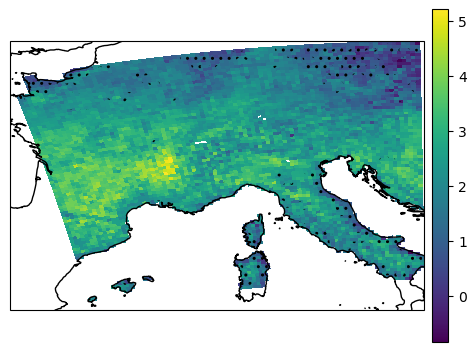

In [113]:
i=1
CS=eval(execute_array_rcp85[W])[i, :, :, :].mean(dim=('time')) - eval(execute_array_his[W])[i, :, :, :].mean(dim=('time'))

cmap = mcolors.ListedColormap(['red', 'none'])
fig, axes = plt.subplots(ncols=1,nrows=1, subplot_kw={'projection': ccrs.PlateCarree()})
P1 = axes.pcolor(V_rcm.lon,V_rcm.lat,V_rcm,transform=ccrs.PlateCarree())  
P2 = axes.contourf(V_rcm.lon,V_rcm.lat,to_stipple_mask_rcm,hatches=['..'],alpha=0,transform=ccrs.PlateCarree())  

lon_grid = np.where(to_hatch_mask_rcm == 1,V_rcm.lon,np.nan)
lat_grid = np.where(to_hatch_mask_rcm == 1,V_rcm.lat,np.nan)
axes.plot(lon_grid, lat_grid, 'k*', markersize=4, transform=ccrs.PlateCarree())

cb = fig.colorbar(P1, ax=(axes), orientation='vertical',shrink=.90,pad=.015)#extend

axes.coastlines(linewidth = 1)


### Plot difference betwee pvalue and pvale adjusted

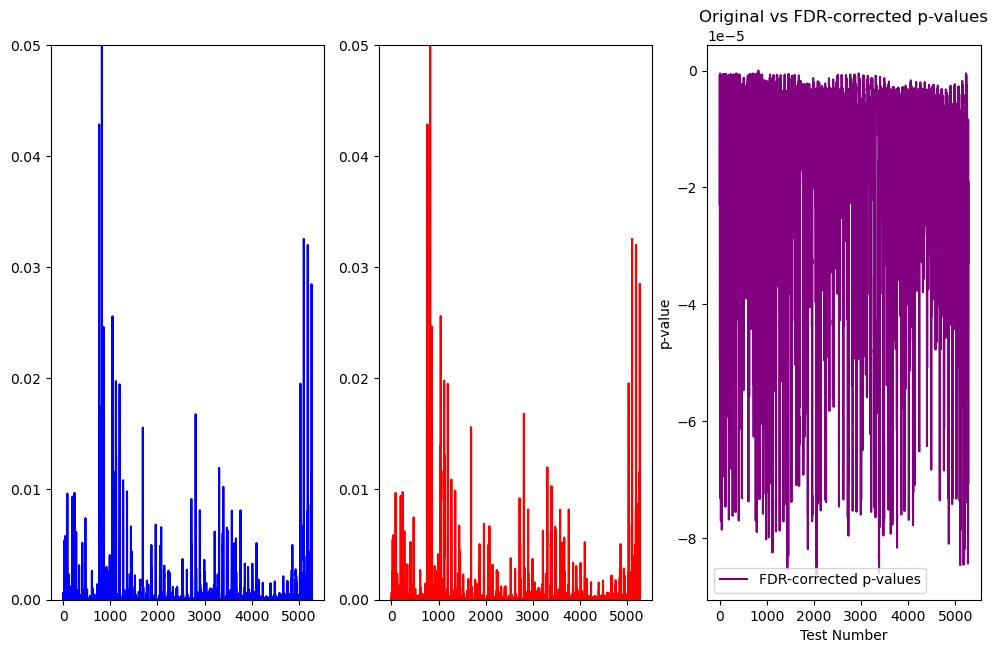

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already generated `corrected_p_values` and `p_values_filtered`
# Let's create the 2D line plot

# Create a figure and axis for plotting
fig, axes = plt.subplots(ncols=3,nrows=1, figsize=(12,7.2))

# Plot the original p-values (filtered)
axes[0].plot(np.arange(len(p_values_filtered)), p_values_filtered, label="Original p-values", color='blue')
axes[0].set_ylim(0,0.05)

# Plot the FDR-corrected p-values
axes[1].plot(np.arange(len(corrected_p_values)), corrected_p_values, label="FDR-corrected p-values", color='red')
axes[1].set_ylim(0,0.05)

axes[2].plot(np.arange(len(corrected_p_values)), p_values_filtered-corrected_p_values, label="FDR-corrected p-values", color='purple')

# Add labels, title, and legend
plt.xlabel("Test Number")
plt.ylabel("p-value")
plt.title("Original vs FDR-corrected p-values")
plt.legend()
# Show the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Create subplots
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

# Estimate PDFs using gaussian_kde for the p-values
kde_p_values_filtered = gaussian_kde(p_values_filtered)
kde_corrected_p_values = gaussian_kde(corrected_p_values)

# Define the range for the x-axis based on the p-values
x_min = min(np.min(p_values_filtered), np.min(corrected_p_values))
x_max = max(np.max(p_values_filtered), np.max(corrected_p_values))
x_range = np.linspace(x_min, x_max, 1000)

# Plot the PDFs of original and corrected p-values in the left panel
axes[0].plot(x_range, kde_p_values_filtered(x_range), label="Original p-values", color='blue')
axes[0].plot(x_range, kde_corrected_p_values(x_range), label="FDR-corrected p-values", color='red')
axes[0].set_xlabel("p-value")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].set_title(f'{var} Original vs FDR-corrected p-values')

# Compute the difference between p-values and estimate the PDF of the difference
p_value_diff = p_values_filtered - corrected_p_values
kde_p_value_diff = gaussian_kde(p_value_diff)

# Define the x-axis range for the difference
x_range_diff = np.linspace(np.min(p_value_diff), np.max(p_value_diff), 1000)

# Plot the PDF of the difference in the right panel
axes[1].plot(x_range_diff, kde_p_value_diff(x_range_diff), color='purple')
axes[1].set_xlabel("p-value difference (original - corrected)")
axes[1].set_ylabel("Density")
axes[1].set_title(f'{var} p-value difference')

# Set overarching title for the entire figure
plt.suptitle(f'{var} p-value Distribution Analysis')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## CPRCMs

In [114]:
res='CPRCM'

models_ranked_to_plot = [ 'BCCR-AUTH','FZJ-IDL','BTU','CMCC','KIT','ETHZ',
                         'HCLIM','KNMI','CNRM','ICTP','UKMO','JLU']

models = [ 'BCCR-AUTH','BTU','CMCC','CNRM','ETHZ','FZJ-IDL','HCLIM',
          'ICTP','KIT','KNMI','UKMO','JLU']

dir_home_his     = f'{root_dir}/scripts/python_2/hws/OUTPUTS/historical/CP'
dir_home_rcp85   = f'{root_dir}/scripts/python_2/hws/OUTPUTS/rcp85/CP'


# Load datasets
ds_his = []
ds_his = xr.open_mfdataset(f'{dir_home_his}/*.nc',combine='nested',concat_dim='model')
ds_his.load()
ds_his = ds_his.sel(model=models_ranked_to_plot)
ds_his['lat'] = ds_his.lat.mean(dim='model')
ds_his['lon'] = ds_his.lon.mean(dim='model')

ds_rcp85 = []
ds_rcp85 = xr.open_mfdataset(f'{dir_home_rcp85}/*.nc',combine='nested',concat_dim='model')
ds_rcp85.load()
ds_rcp85 = ds_rcp85.sel(model=models_ranked_to_plot)
ds_rcp85['lat'] = ds_rcp85.lat.mean(dim='model')
ds_rcp85['lon'] = ds_rcp85.lon.mean(dim='model')


if do_plot == 'his' :
    if W < 2 : 
        V_cprcm = eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='CPRCMs')-273.16
        #V_cprcm = eval(execute_array_his[W]).mean(dim='time').mean(dim='model').assign_coords(ENS='CPRCMs')-273.16
    else : 
        V_cprcm = eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='CPRCMs')
        #V_cprcm = eval(execute_array_his[W]).mean(dim='time').mean(dim='model').assign_coords(ENS='CPRCMs')  
    V_cprcm = V_cprcm.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    V_cprcm_std = eval(execute_array_his[W]).mean(dim='time').std(dim='model').assign_coords(ENS='CPRCMs')
    
if do_plot == 'ccs' : 
    V_cprcm = eval(execute_array_rcp85[W]).mean(dim='time').quantile(.5, dim='model') - eval(execute_array_his[W]).mean(dim='time').quantile(.5, dim='model').assign_coords(ENS='RCMs')
    #V_cprcm = eval(execute_array_rcp85[W]).mean(dim='time').mean(dim='model') - eval(execute_array_his[W]).mean(dim='time').mean(dim='model').assign_coords(ENS='CPRCMs')
    V_cprcm = V_cprcm.assign_coords(lon=ds_his.lon, lat=ds_his.lat)
    V_cprcm_std = np.std(eval(execute_array_rcp85[W]).mean(dim='time') - eval(execute_array_his[W]).mean(dim='time').assign_coords(ENS='CPRCMs'),axis=0)
    V_cprcm_std = V_cprcm_std.assign_coords(lon=ds_his.lon, lat=ds_his.lat)

    dummy_p_mat = np.empty([len(models),ds_his.HW_mean_tmax.shape[2],ds_his.HW_mean_tmax.shape[3]])
    dummy_p_mat_fdr = np.empty([len(models),ds_his.HW_mean_tmax.shape[2],ds_his.HW_mean_tmax.shape[3]])
    trend_signs = np.empty([len(models), ds_his.HW_mean_tmax.shape[2], ds_his.HW_mean_tmax.shape[3]])

    for i in range(0,len(models)) :
        
        V = eval(execute_array_rcp85[W])[i,:,:,:].mean(dim=('time')) - eval(execute_array_his[W])[i,:,:,:].mean(dim=('time'))

        H = eval(execute_array_his[W])[i,:,:,:];   
        F = eval(execute_array_rcp85[W])[i,:,:,:]; 
            
        # Compute ttest for each model
        s,p=scipy.stats.ttest_ind(H ,F, axis=0, equal_var=False,nan_policy='omit')
        
        dummy_p_mat[i,:,:] = p 
        trend_signs[i, :, :] = np.sign(s)  # Store the sign of the trend based on t-statistic `s`
        
        # FDR     
        # Flatten the p-values and retain a mask of non-NaN values
        p_values_flat = p.flatten()
        non_nan_mask = ~np.isnan(p_values_flat)
            
        # Filter non-NaN p-values
        p_values_filtered = p_values_flat[non_nan_mask]
        
        # If no valid p-values are present, skip to the next iteration
        if len(p_values_filtered) == 0:
            print("No valid p-values for this iteration, skipping.")
                
        # Apply FDR correction
        _, corrected_p_values, _, _ = multipletests(p_values_filtered, alpha=0.05, method='fdr_bh')
        
        # Create an array filled with NaNs (same shape as `p`)
        corrected_p_values_mat = np.full(p.shape, np.nan)
        
        # Instead of using flatten, index directly into the flattened view
        np.put(corrected_p_values_mat, np.where(non_nan_mask)[0], corrected_p_values)
        
        # Store the corrected p-values into dummy_p_mat_fdr
        dummy_p_mat_fdr[i, :, :] = corrected_p_values_mat
    

# Step 1: Test for significant changes using FDR-corrected p-values
# Convert p-values to binary significance mask (1 for significant, NaN for non-significant)
dummy_p_mat[dummy_p_mat > 0.05] = np.NaN
dummy_p_mat[dummy_p_mat <= 0.05] = 1
dummy_p_mat_fdr[dummy_p_mat_fdr > 0.05] = np.NaN
dummy_p_mat_fdr[dummy_p_mat_fdr <= 0.05] = 1


# Step 1: Find how many models show significant trend for each grid point
significant_models_count = np.nansum(dummy_p_mat, axis=0)  # Sum along the model dimension (axis 0)
significant_mask = (np.nansum(~np.isnan(dummy_p_mat),axis=0)/len(models))<.5  # Binary mask for significant trends
# Apply the first mask: Where `significant_mask` is true, keep `significant_models_count`, otherwise set to 9999
to_stipple_mask = np.where(np.isnan(V_cprcm), np.nan, significant_mask)
to_stipple_mask_cprcm = np.where(to_stipple_mask==0, np.nan, to_stipple_mask)

# Step 2: Find the sign of significant trends from each model
trend_sign = np.where(np.isnan(dummy_p_mat), np.nan, trend_signs)
# Derive trend sign agreement, wherever
trend_sign_agreement = np.nansum(trend_sign,axis=0)
# Derive trend sign agreement only over 50% of model shows significant trend
trend_sign_agreement_masked = np.where(significant_mask==0, trend_sign_agreement, np.nan)

# Derive the percentage of the model agreement over the sign where significant trends result 
trend_sign_agreement_masked_percentage = np.abs(trend_sign_agreement_masked)/significant_models_count
# Mask where significant trend sign agreement is lower than .80
to_hatch_mask_cprcm = np.where(trend_sign_agreement_masked_percentage<.66, 1, np.nan)


#fdr-adjusted p-value

# Step 1: Find how many models show significant trend for each grid point
significant_models_count = np.nansum(dummy_p_mat_fdr, axis=0)  # Sum along the model dimension (axis 0)
significant_mask = (np.nansum(~np.isnan(dummy_p_mat_fdr),axis=0)/len(models))<.5  # Binary mask for significant trends
# Apply the first mask: Where `significant_mask` is true, keep `significant_models_count`, otherwise set to 9999
to_stipple_mask = np.where(np.isnan(V_cprcm), np.nan, significant_mask)
to_stipple_mask_fdr_cprcm = np.where(to_stipple_mask==0, np.nan, to_stipple_mask)

# Step 2: Find the sign of significant trends from each model
trend_sign = np.where(np.isnan(dummy_p_mat_fdr), np.nan, trend_signs)
# Derive trend sign agreement, wherever
trend_sign_agreement = np.nansum(trend_sign,axis=0)
# Derive trend sign agreement only over 50% of model shows significant trend
trend_sign_agreement_masked = np.where(significant_mask==0, trend_sign_agreement, np.nan)

# Derive the percentage of the model agreement over the sign where significant trends result 
trend_sign_agreement_masked_percentage = np.abs(trend_sign_agreement_masked)/significant_models_count
# Mask where significant trend sign agreement is lower than .80
to_hatch_mask_fdr_cprcm = np.where(trend_sign_agreement_masked_percentage<.66, 1, np.nan)


/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


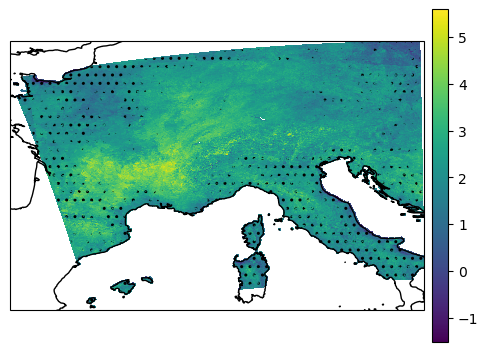

In [111]:

fig, axes = plt.subplots(ncols=1,nrows=1, subplot_kw={'projection': ccrs.PlateCarree()})
P1 = axes.pcolor(V_cprcm.lon,V_cprcm.lat,V_cprcm,transform=ccrs.PlateCarree())  
P2 = axes.contourf(V_cprcm.lon,V_cprcm.lat,to_stipple_mask_fdr_cprcm,hatches=['..'],alpha=0,transform=ccrs.PlateCarree())  

lon_grid = np.where(to_hatch_mask_fdr_cprcm == 1,V_cprcm.lon,np.nan)
lat_grid = np.where(to_hatch_mask_fdr_cprcm == 1,V_cprcm.lat,np.nan)
axes.plot(lon_grid, lat_grid, 'r*', markersize=2, transform=ccrs.PlateCarree())

cb = fig.colorbar(P1, ax=(axes), orientation='vertical',shrink=.90,pad=.015)#extend

axes.coastlines(linewidth = 1)

### Plot HISTORICAL

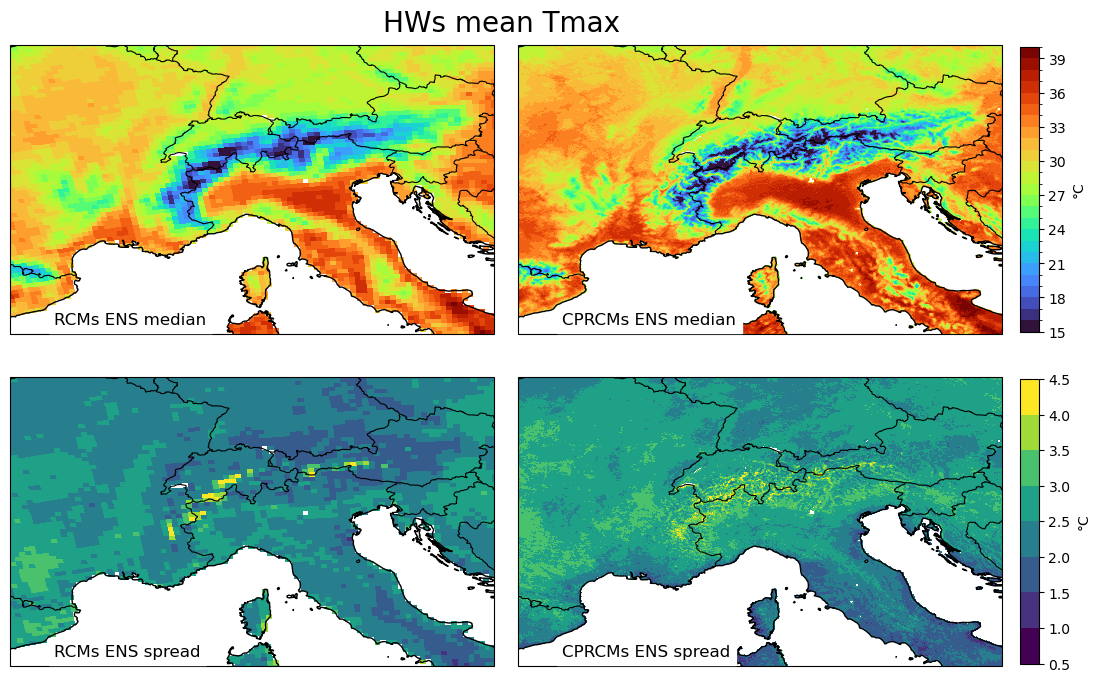

In [79]:
if D == 'his' : 
    
    cmap = plt.get_cmap(colormap_his[W], len(levels_his) - 1)  # Use len(levels) - 1 colors
    cmap_std = plt.get_cmap(colormap_std, len(levels_std) - 1)  
    
    norm = mcolors.BoundaryNorm(levels_his, cmap.N, clip=False)
    norm_std = mcolors.BoundaryNorm(levels_std, cmap_std.N, clip=False)
    
    fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(12,7.2),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    
    
    P1 = axes[0,0].pcolormesh(
            V_rcm.lon,
            V_rcm.lat,
            V_rcm,
            cmap=cmap,
            norm=norm,
            transform=ccrs.PlateCarree())    

    P2 = axes[0,1].pcolormesh(
            V_cprcm.lon,
            V_cprcm.lat,
            V_cprcm,
            cmap=cmap,
            norm=norm,
            transform=ccrs.PlateCarree())    
    
    
    # RCMs STDEV
    P3 = axes[1,0].pcolormesh(V_rcm.lon, V_rcm.lat, V_rcm_std, cmap=cmap_std,norm=norm_std,            
                        transform=ccrs.PlateCarree())

    # CPRCMs STDEV
    P4 = axes[1,1].pcolormesh(V_cprcm.lon, V_cprcm.lat, V_cprcm_std,cmap=cmap_std,norm=norm_std,         
                        transform=ccrs.PlateCarree())


    axes[0,0].coastlines(linewidth = 1)
    axes[0,0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0,0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0,0].set_facecolor('white')
    axes[0,0].text(2.45,40.8,'RCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
        
    axes[0,1].coastlines(linewidth = 1)
    axes[0,1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0,1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0,1].set_facecolor('white')
    axes[0,1].text(2.45,40.8,'CPRCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1,color='k')
    axes[0,1].set_title(f'')

    
    axes[1,0].coastlines(linewidth=1)
    axes[1,0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1,0].add_feature(cfeature.BORDERS, linewidth=0.8)
    axes[1,0].set_facecolor('white')
    axes[1,0].text(2.45,40.8,'RCMs ENS spread',fontsize=12,backgroundcolor='w',alpha=1,color='k')
    axes[1,0].set_title(f'')
    
    axes[1,1].coastlines(linewidth=1)
    axes[1,1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1,1].add_feature(cfeature.BORDERS, linewidth=0.8)
    axes[1,1].set_facecolor('white')
    axes[1,1].text(2.45,40.8,'CPRCMs ENS spread',fontsize=12,backgroundcolor='w',alpha=1,color='k')
    axes[1,1].set_title(f'')

    
    fig.subplots_adjust(left=.01,right=1, bottom=.05,top=.95,wspace=.05,hspace=.05)
    
    cb = fig.colorbar(P2, ax=(axes[0,0],axes[0,1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.90,pad=.015)
    cb = fig.colorbar(P4, ax=(axes[1,0],axes[1,1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.90,pad=.015)

    
    # Create a common title for the upper two panels
    fig.text(0.42, 0.95, f'{var_to_tit}', fontsize=20, ha='center')
    #fig.text(0.42, 0.47, f'{var_to_tit} CCS spread', fontsize=20, ha='center')
    
    
    #plt.savefig(f'{fig_dir}/ensemble_{do_plot}_{var}.png')
    plt.show()


### Compute biases

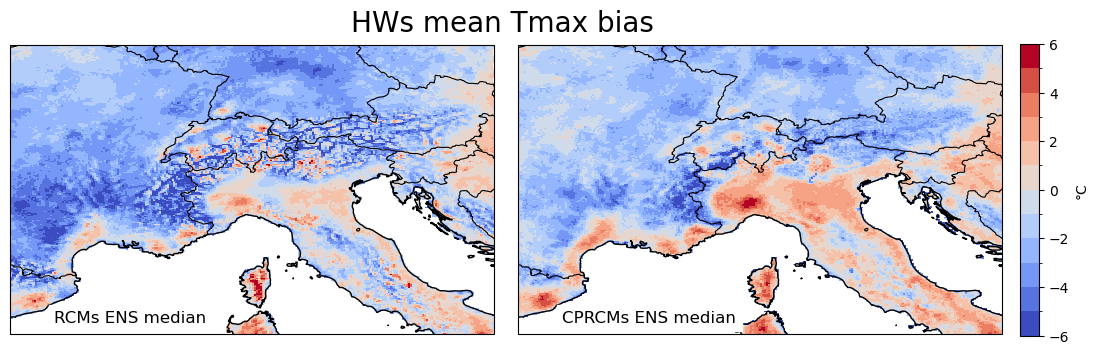

In [80]:
VARS=['HW_mean_tmax','HW_max_tmax','HW_persistence','HW_HWMI','HW_number']


# Define colormaps for bias_rcm and bias_cprcm
cmap_rcm = plt.get_cmap('coolwarm')  # Replace 'coolwarm' with your desired colormap
cmap_cprcm = plt.get_cmap('coolwarm')  # Replace 'coolwarm' with your desired colormap

# Create a BoundaryNorm for discrete levels
norm_rcm = mcolors.BoundaryNorm(levels_bias, cmap_rcm.N, clip=False)
norm_cprcm = mcolors.BoundaryNorm(levels_bias, cmap_cprcm.N, clip=False)
    
cmap = plt.get_cmap(colormap_bias, len(levels_bias))
 
if D == 'his' : 
    
    fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(12,7.2),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    
    # MEAN BIAS ON EMO5
    # Interpolate SIMs to a SIM reference grid
    ds_emo5 = xr.open_mfdataset(f'{root_dir}/scripts/python_2/hws/OUTPUTS/historical/EMO-5-tx_1996_2005_JJA.nc')
    dataset = Dataset(f'{root_dir}/scripts/python_2/hws/OUTPUTS/historical/EMO-5-tx_1996_2005_JJA.nc', mode='r')
    da_emo5 = xr.DataArray(dataset.variables[f'{VARS[W_EMO5]}'][:]).rename({'dim_0':'time','dim_1':'lat','dim_2':'lon'})
    V_emo5 = da_emo5.mean(dim='time')
    
    # Interpolation of simulations to observations grid.
    mask_emo5 = ds_emo5.HW_mean_tmax[0,:,:].where(ds_emo5.HW_mean_tmax[0,:,:]!=np.nan).compute()

    method = 'bilinear'
    def regrid(ds,ds_out,method):
        regridder = xe.Regridder(ds,ds_out, method = method)
        ds = regridder(ds,ds_out,method)
        return ds

    mod=V_rcm
    mod = mod.to_dataset()
    mod_regr = regrid(mod,ds_emo5,method)
    bias = xr.DataArray(mod_regr.to_array().squeeze().values - V_emo5.values).rename({'dim_0':'y','dim_1':'x'})
    bias_rcm = bias.where(mask_emo5,drop=True)

    mod=V_cprcm
    mod = mod.to_dataset()
    mod_regr = regrid(mod,ds_emo5,method)
    bias = xr.DataArray(mod_regr.to_array().squeeze().values - V_emo5.values).rename({'dim_0':'y','dim_1':'x'})
    bias_cprcm = bias.where(mask_emo5,drop=True)


    
    P1 = axes[0].pcolormesh(
            ds_emo5.lon,
            ds_emo5.lat,
            bias_rcm,
            cmap=cmap_rcm,
            norm=norm_rcm,
            transform=ccrs.PlateCarree())    

    P2 = axes[1].pcolormesh(
            ds_emo5.lon,
            ds_emo5.lat,
            bias_cprcm,
            cmap=cmap_cprcm,
            norm=norm_cprcm,
            transform=ccrs.PlateCarree())    

    axes[0].coastlines(linewidth = 1)
    axes[0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0].set_facecolor('white')
    axes[0].text(2.45,40.9,'RCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)   


    axes[1].coastlines(linewidth = 1)
    axes[1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1].set_facecolor('white')
    axes[1].text(2.45,40.9,'CPRCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    
    
    # Create a common title for the upper two panels
    fig.text(0.42, 0.72, f'{var_to_tit} bias', fontsize=20, ha='center')
    
    fig.subplots_adjust(left=.01,right=1, bottom=.05,top=.95,wspace=.05,hspace=.05)
   
    cb = fig.colorbar(P2, ax=(axes[0],axes[1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.45,pad=.015)
    
    #plt.savefig(f'{fig_dir}/ensembles_{do_plot}_{var}_bias.png')  
    plt.show()



### Plot where nonCP_bias - CP_bias > 0 

/users_home/cmcc/ls21622/.conda/envs/DEVELOP/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


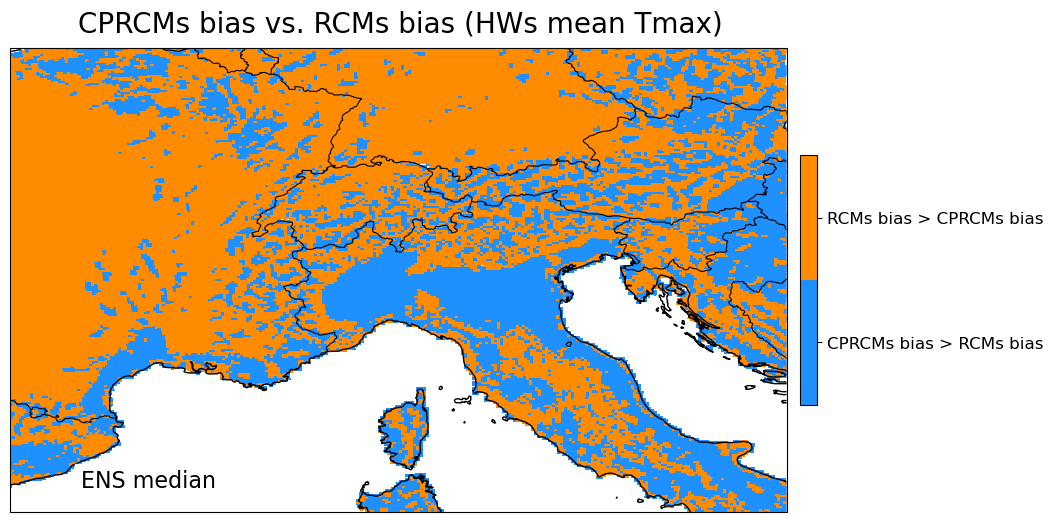

In [81]:
if D == 'his' : 
    #Calculate difference bias
    diff_bias = np.abs(bias_cprcm) - np.abs(bias_rcm)
    # Create masks
    array = np.empty(np.shape(diff_bias)) * np.nan
    array[diff_bias>0]=-1
    array[diff_bias<0]=1

    cmap = mcolors.ListedColormap(['dodgerblue', 'darkorange'])  # Black for > 0, white for <= 0
    bounds = [-1, 1]  # Boundaries for color mapping
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    # Plot
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(12/1, 7.2/1),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot the composite array with the custom colormap
    P1 = axes.pcolor(ds_emo5.lon, ds_emo5.lat, array, cmap=cmap,transform=ccrs.PlateCarree())
    # Add coastlines and other features
    axes.coastlines(linewidth=1, color='black')
    axes.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes.add_feature(cartopy.feature.BORDERS, linewidth=.8, color='black')
    #axes.set_facecolor('red')
    axes.text(2.45, 41, 'ENS median', fontsize=16, backgroundcolor='w', alpha=1)
    
    #axes.set_title('CPRCMs bias vs RCMs bias (HWs mean Tmax)', fontsize=12, backgroundcolor='r', alpha=1,zorder=1)

    fig.text(0.45, 0.84, f'CPRCMs bias vs. RCMs bias (HWs mean Tmax)', fontsize=20, ha='center')
    
    cb = fig.colorbar(P1, ax=axes, orientation='vertical', aspect=15, shrink=.45, pad=.015)
    cb.set_ticks([-0.5, 0.5])  # Two ticks for the two regions (white and black)
    cb.set_ticklabels(['CPRCMs bias > RCMs bias', 'RCMs bias > CPRCMs bias'], fontsize=12)  # Custom labels
    
    #plt.show()
    plt.savefig('CPRCM_bias_vs_RCM_bias.png',dpi=300)

## Plot CCS

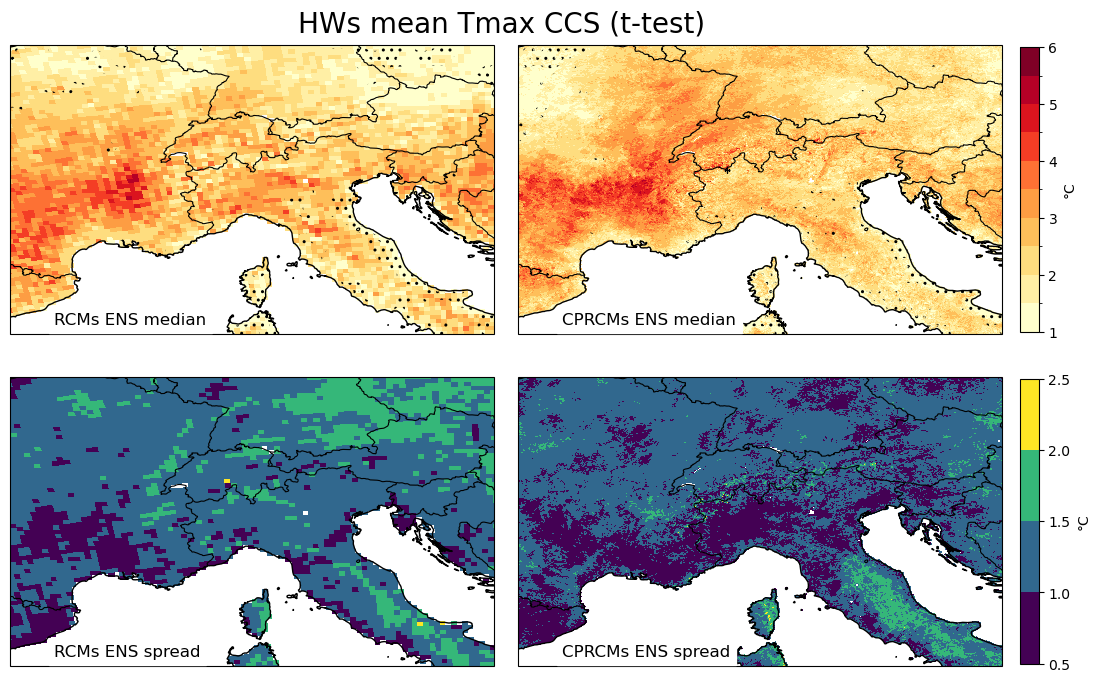

In [126]:
if D == 'ccs' : 
    
    # Create a colormap with your custom levels
    cmap = plt.get_cmap(colormap_ccs[W], len(levels_ccs) - 1)
    cmap_std = plt.get_cmap(colormap_std,len(levels_std) - 1)
    # Create a BoundaryNorm for discrete levels
    norm = mcolors.BoundaryNorm(levels_ccs, cmap.N, clip=False)
    norm_std = mcolors.BoundaryNorm(levels_std, cmap_std.N, clip=False)
    
    fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(12,7.2),
                             subplot_kw={'projection': ccrs.PlateCarree()})
        
    
    # Set the value for which you want to apply hatching
    hatch_value = 9999
    
    
    P1 = axes[0,0].pcolormesh(
            V_rcm.lon,
            V_rcm.lat,
            V_rcm.squeeze(),
            cmap=cmap,
            norm=norm,
            transform=ccrs.PlateCarree())    

    P2 = axes[0,1].pcolormesh(
            V_cprcm.lon,
            V_cprcm.lat,
            V_cprcm.squeeze(),
            cmap=cmap,
            norm=norm,
            transform=ccrs.PlateCarree())    
    
    P3 = axes[1,0].pcolormesh(
            V_rcm_std.lon,
            V_rcm_std.lat,
            V_rcm_std.squeeze(),
            cmap=cmap_std,
            norm=norm_std,
            transform=ccrs.PlateCarree())    

    P4 = axes[1,1].pcolormesh(
            V_cprcm_std.lon,
            V_cprcm_std.lat,
            V_cprcm_std.squeeze(),
            cmap=cmap_std,
            norm=norm_std,
            transform=ccrs.PlateCarree())    
   

    axes[0,0].contourf(V_rcm.lon,V_rcm.lat,to_stipple_mask_rcm,hatches=['..'],alpha=0.0,transform=ccrs.PlateCarree()) 
    lon_grid = np.where(to_hatch_mask_rcm == 1,V_rcm.lon,np.nan)
    lat_grid = np.where(to_hatch_mask_rcm == 1,V_rcm.lat,np.nan)
    axes[0,0].plot(lon_grid, lat_grid, 'k+', markersize=5, transform=ccrs.PlateCarree())
    
    axes[0,1].contourf(V_cprcm.lon,V_cprcm.lat,to_stipple_mask_cprcm,hatches=['..'],alpha=0.0,transform=ccrs.PlateCarree()) 
    lon_grid = np.where(to_hatch_mask_cprcm == 1,V_cprcm.lon,np.nan)
    lat_grid = np.where(to_hatch_mask_cprcm == 1,V_cprcm.lat,np.nan)
    axes[0,1].plot(lon_grid, lat_grid, 'k+', markersize=5, transform=ccrs.PlateCarree())
    
  
    axes[0,0].coastlines(linewidth = 1)
    axes[0,0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0,0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0,0].set_facecolor('white')
    axes[0,0].text(2.45,40.8,'RCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    
    axes[0,1].coastlines(linewidth = 1)
    axes[0,1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0,1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0,1].set_facecolor('white')
    axes[0,1].text(2.45,40.8,'CPRCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    

    axes[1,0].coastlines(linewidth = 1)
    axes[1,0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1,0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1,0].set_facecolor('white')
    axes[1,0].text(2.45,40.8,'RCMs ENS spread',fontsize=12,backgroundcolor='w',alpha=1)
    
    axes[1,1].coastlines(linewidth = 1)
    axes[1,1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1,1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1,1].set_facecolor('white')
    axes[1,1].text(2.45,40.8,'CPRCMs ENS spread',fontsize=12,backgroundcolor='w',alpha=1)
    
    fig.subplots_adjust(left=.01,right=1, bottom=.05,top=.95,wspace=.05,hspace=.05)
    
    cb = fig.colorbar(P2, ax=(axes[0,0],axes[0,1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.90,pad=.015)#extend
    cb = fig.colorbar(P4, ax=(axes[1,0],axes[1,1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.90,pad=.015)

    
    # Create a common title for the upper two panels
    fig.text(0.42, 0.95, f'{var_to_tit} CCS (t-test)', fontsize=20, ha='center')
  
    #plt.savefig(f'{fig_dir}/ensembles_{do_plot}_{var}.png')  
    plt.savefig(f'/users_home/cmcc/ls21622/tmp/ensembles_{do_plot}_{var}_ttest.png',dpi=300)  
    plt.show()

### Plot CCS with t-test CDR adjustement 

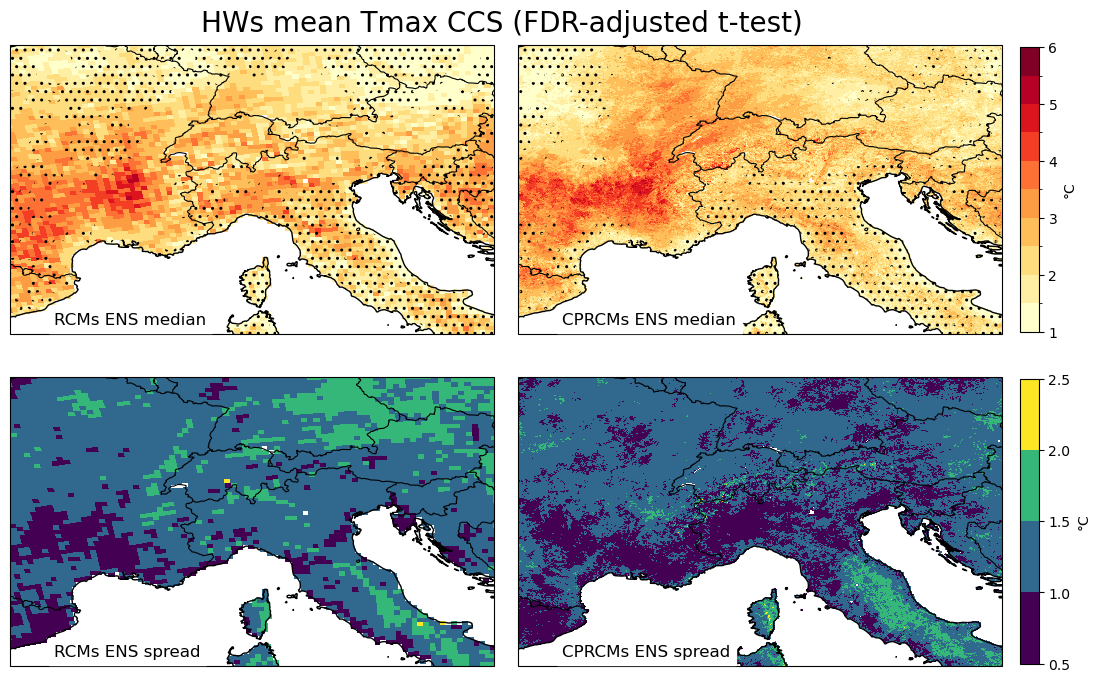

In [127]:
if D == 'ccs' : 
    
    # Create a colormap with your custom levels
    cmap = plt.get_cmap(colormap_ccs[W], len(levels_ccs) - 1)
    cmap_std = plt.get_cmap(colormap_std,len(levels_std) - 1)
    # Create a BoundaryNorm for discrete levels
    norm = mcolors.BoundaryNorm(levels_ccs, cmap.N, clip=False)
    norm_std = mcolors.BoundaryNorm(levels_std, cmap_std.N, clip=False)
    
    fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(12,7.2),
                             subplot_kw={'projection': ccrs.PlateCarree()})
        
    
    # Set the value for which you want to apply hatching
    hatch_value = 9999
    
    
    P1 = axes[0,0].pcolormesh(
            V_rcm.lon,
            V_rcm.lat,
            V_rcm.squeeze(),
            cmap=cmap,
            norm=norm,
            transform=ccrs.PlateCarree())    

    P2 = axes[0,1].pcolormesh(
            V_cprcm.lon,
            V_cprcm.lat,
            V_cprcm.squeeze(),
            cmap=cmap,
            norm=norm,
            transform=ccrs.PlateCarree())    
    
    P3 = axes[1,0].pcolormesh(
            V_rcm_std.lon,
            V_rcm_std.lat,
            V_rcm_std.squeeze(),
            cmap=cmap_std,
            norm=norm_std,
            transform=ccrs.PlateCarree())    

    P4 = axes[1,1].pcolormesh(
            V_cprcm_std.lon,
            V_cprcm_std.lat,
            V_cprcm_std.squeeze(),
            cmap=cmap_std,
            norm=norm_std,
            transform=ccrs.PlateCarree())    
   

    axes[0,0].contourf(V_rcm.lon,V_rcm.lat,to_stipple_mask_fdr_rcm,hatches=['..'],alpha=0.0,transform=ccrs.PlateCarree()) 
    lon_grid = np.where(to_hatch_mask_fdr_rcm == 1,V_rcm.lon,np.nan)
    lat_grid = np.where(to_hatch_mask_fdr_rcm == 1,V_rcm.lat,np.nan)
    axes[0,0].plot(lon_grid, lat_grid, 'k+', markersize=5, transform=ccrs.PlateCarree())
    
    axes[0,1].contourf(V_cprcm.lon,V_cprcm.lat,to_stipple_mask_fdr_cprcm,hatches=['..'],alpha=0.0,transform=ccrs.PlateCarree()) 
    lon_grid = np.where(to_hatch_mask_fdr_cprcm == 1,V_cprcm.lon,np.nan)
    lat_grid = np.where(to_hatch_mask_fdr_cprcm == 1,V_cprcm.lat,np.nan)
    axes[0,1].plot(lon_grid, lat_grid, 'k+', markersize=5, transform=ccrs.PlateCarree())
    
  
    axes[0,0].coastlines(linewidth = 1)
    axes[0,0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0,0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0,0].set_facecolor('white')
    axes[0,0].text(2.45,40.8,'RCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    
    axes[0,1].coastlines(linewidth = 1)
    axes[0,1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0,1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0,1].set_facecolor('white')
    axes[0,1].text(2.45,40.8,'CPRCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    

    axes[1,0].coastlines(linewidth = 1)
    axes[1,0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1,0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1,0].set_facecolor('white')
    axes[1,0].text(2.45,40.8,'RCMs ENS spread',fontsize=12,backgroundcolor='w',alpha=1)
    
    axes[1,1].coastlines(linewidth = 1)
    axes[1,1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1,1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1,1].set_facecolor('white')
    axes[1,1].text(2.45,40.8,'CPRCMs ENS spread',fontsize=12,backgroundcolor='w',alpha=1)
    
    fig.subplots_adjust(left=.01,right=1, bottom=.05,top=.95,wspace=.05,hspace=.05)
    
    cb = fig.colorbar(P2, ax=(axes[0,0],axes[0,1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.90,pad=.015)#extend
    cb = fig.colorbar(P4, ax=(axes[1,0],axes[1,1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.90,pad=.015)

    
    # Create a common title for the upper two panels
    fig.text(0.42, 0.95, f'{var_to_tit} CCS (FDR-adjusted t-test)', fontsize=20, ha='center')
  
    #plt.savefig(f'{fig_dir}/ensembles_{do_plot}_{var}.png')  
    plt.savefig(f'/users_home/cmcc/ls21622/tmp/ensembles_{do_plot}_{var}_ttest_fdr_adjusted.png',dpi=300)  
    plt.show()

### Call for monte carlo test 

In [16]:
ds_montecarlo_RCM=xr.open_dataset(f'/data/cmcc/ls21622/gcm_driven_experiment_from_nird/scripts/python_2/hws/OUTPUTS/monte_carlo_test/monte_carlo_results_095_RCM_{variables[W]}.nc')
ds_montecarlo_CPRCM=xr.open_dataset(f'/data/cmcc/ls21622/gcm_driven_experiment_from_nird/scripts/python_2/hws/OUTPUTS/monte_carlo_test/monte_carlo_results_095_CPRCM_{variables[W]}.nc')
da_consensus_significant_RCM=ds_montecarlo_RCM.consensus_significant.where(~np.isnan(V_rcm.rename({'y':'lat','x':'lon'})))
da_consensus_significant_CPRCM=ds_montecarlo_CPRCM.consensus_significant.where(~np.isnan(V_cprcm.rename({'y':'lat','x':'lon'})))
da_consensus_significant_RCM = da_consensus_significant_RCM.where(da_consensus_significant_RCM == 0, np.nan)
da_consensus_significant_CPRCM = da_consensus_significant_CPRCM.where(da_consensus_significant_CPRCM == 0, np.nan)

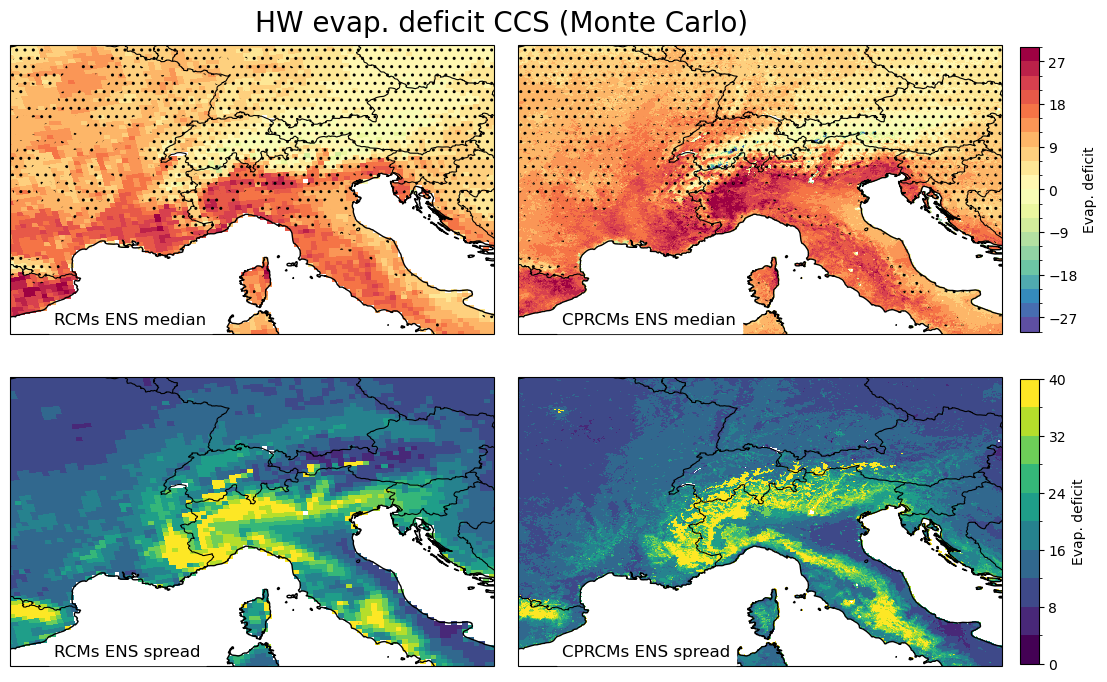

In [17]:
if D == 'ccs' : 

    # Create a colormap with your custom levels
    cmap = plt.get_cmap(colormap_ccs[W], len(levels_ccs) - 1)
    cmap_std = plt.get_cmap(colormap_std,len(levels_std) - 1)
    # Create a BoundaryNorm for discrete levels
    norm = mcolors.BoundaryNorm(levels_ccs, cmap.N, clip=False)
    norm_std = mcolors.BoundaryNorm(levels_std, cmap_std.N, clip=False)
    
    fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(12,7.2),
                             subplot_kw={'projection': ccrs.PlateCarree()})
        
    
    # Set the value for which you want to apply hatching
    hatch_value = 9999
    
    
    P1 = axes[0,0].pcolormesh(
            V_rcm.lon,
            V_rcm.lat,
            V_rcm.squeeze(),
            cmap=cmap,
            norm=norm,
            transform=ccrs.PlateCarree())    

    P2 = axes[0,1].pcolormesh(
            V_cprcm.lon,
            V_cprcm.lat,
            V_cprcm.squeeze(),
            cmap=cmap,
            norm=norm,
            transform=ccrs.PlateCarree())    
    
    P3 = axes[1,0].pcolormesh(
            V_rcm_std.lon,
            V_rcm_std.lat,
            V_rcm_std.squeeze(),
            cmap=cmap_std,
            norm=norm_std,
            transform=ccrs.PlateCarree())    

    P4 = axes[1,1].pcolormesh(
            V_cprcm_std.lon,
            V_cprcm_std.lat,
            V_cprcm_std.squeeze(),
            cmap=cmap_std,
            norm=norm_std,
            transform=ccrs.PlateCarree())    
   

    axes[0,0].contourf(            
        V_rcm.lon,
        V_rcm.lat,
        da_consensus_significant_RCM,
        hatches=['..'],
        alpha=0.0,
        transform=ccrs.PlateCarree())   
    
    
    axes[0,1].contourf(            
        V_cprcm.lon,
        V_cprcm.lat,
        da_consensus_significant_CPRCM,
        hatches=['..'],
        alpha=0.0,
        transform=ccrs.PlateCarree()) 
    
    
  
    axes[0,0].coastlines(linewidth = 1)
    axes[0,0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0,0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0,0].set_facecolor('white')
    axes[0,0].text(2.45,40.8,'RCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    
    axes[0,1].coastlines(linewidth = 1)
    axes[0,1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[0,1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[0,1].set_facecolor('white')
    axes[0,1].text(2.45,40.8,'CPRCMs ENS median',fontsize=12,backgroundcolor='w',alpha=1)
    

    axes[1,0].coastlines(linewidth = 1)
    axes[1,0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1,0].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1,0].set_facecolor('white')
    axes[1,0].text(2.45,40.8,'RCMs ENS spread',fontsize=12,backgroundcolor='w',alpha=1)
    
    axes[1,1].coastlines(linewidth = 1)
    axes[1,1].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    axes[1,1].add_feature(cartopy.feature.BORDERS,linewidth=.8)
    axes[1,1].set_facecolor('white')
    axes[1,1].text(2.45,40.8,'CPRCMs ENS spread',fontsize=12,backgroundcolor='w',alpha=1)
    
    fig.subplots_adjust(left=.01,right=1, bottom=.05,top=.95,wspace=.05,hspace=.05)
    
    cb = fig.colorbar(P2, ax=(axes[0,0],axes[0,1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.90,pad=.015)#extend
    cb = fig.colorbar(P4, ax=(axes[1,0],axes[1,1]), orientation='vertical',
                      label=clabs[W],aspect=15,shrink=.90,pad=.015)

    
    # Create a common title for the upper two panels
    fig.text(0.42, 0.95, f'{var_to_tit} CCS (Monte Carlo)', fontsize=20, ha='center')
  
    #plt.savefig(f'{fig_dir}/ensembles_{do_plot}_{var}.png')  
    #plt.savefig(f'./ensembles_monte_carlo_{do_plot}_{var}_montecarlo.png',dpi=300)  
    plt.show()
